# Train a Neural Network to Predict Quality of Wine
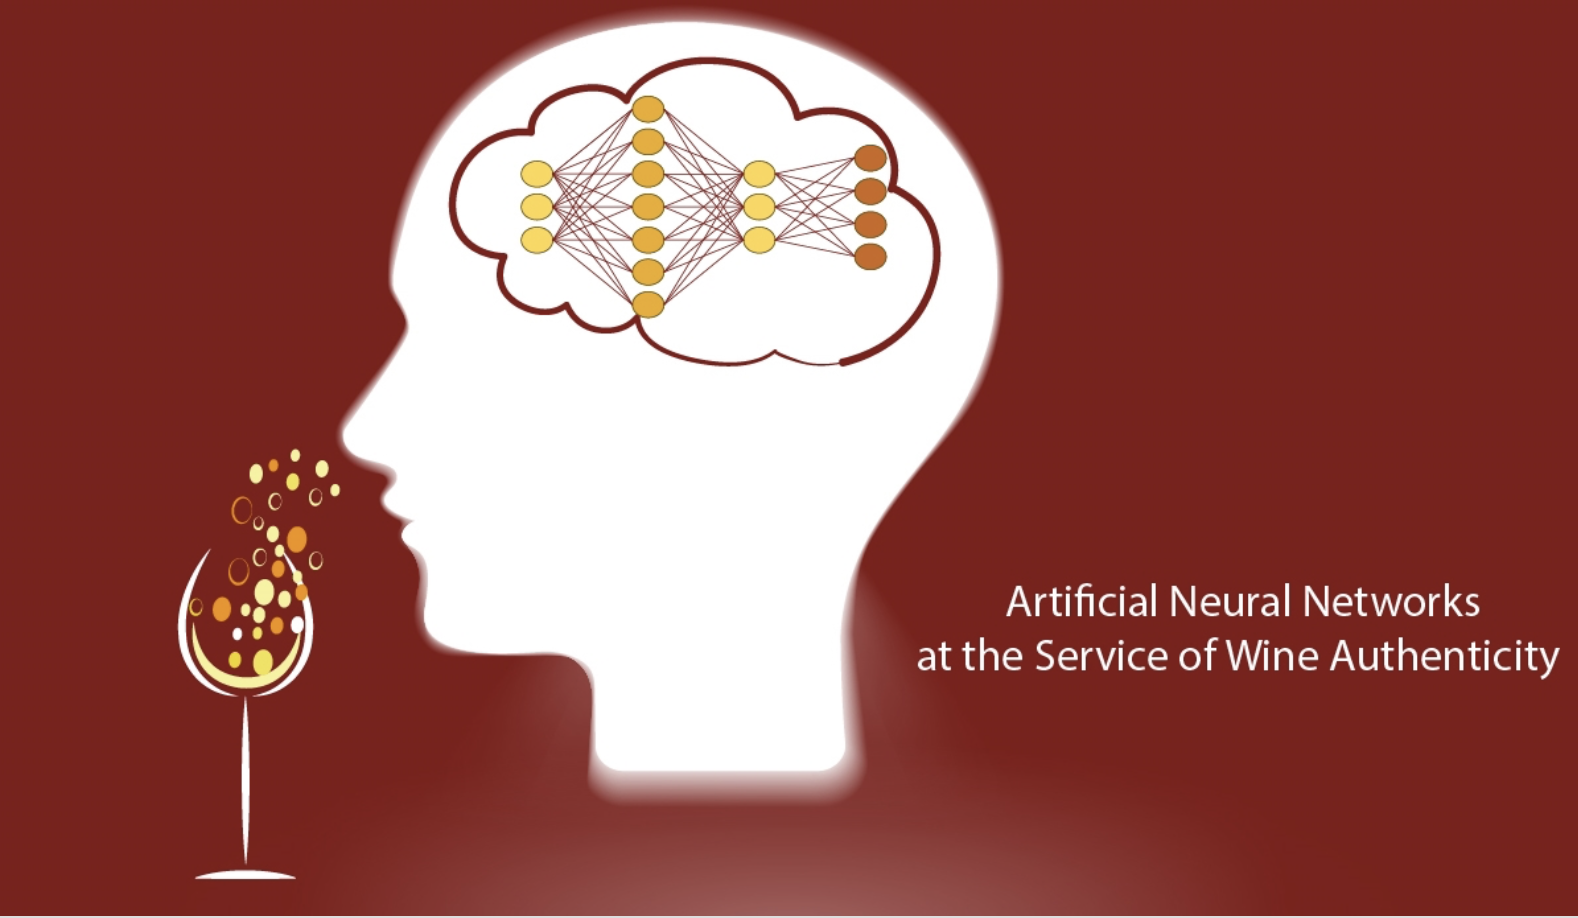
* In this lab, you will first train a neural network on a public dataset, then make several enhancements to the lab.
* Tasks breakdown:
  * Code running: 10%
  * Enhancement 1: 15%
  * Enhancement 2: 15%
  * Enhancement 3: 10%
  * Enhancement 4: 10%
  * Enhancement 5: 40%


## Imports

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Dataset

In [ ]:
data_df = pd.read_csv('glass.csv')

In [ ]:
data_df.head()

RI     Na    Mg    Al     Si     K    Ca   Ba   Fe  Type
0  1.52101  13.64  4.49  1.10  71.78  0.06  8.75  0.0  0.0     1
1  1.51761  13.89  3.60  1.36  72.73  0.48  7.83  0.0  0.0     1
2  1.51618  13.53  3.55  1.54  72.99  0.39  7.78  0.0  0.0     1
3  1.51766  13.21  3.69  1.29  72.61  0.57  8.22  0.0  0.0     1
4  1.51742  13.27  3.62  1.24  73.08  0.55  8.07  0.0  0.0     1

In [ ]:
# how many features?
len(data_df.columns) - 1

9

In [ ]:
# how many labels? If yours is a binary classification task, then you'll have 2 labels.
data_df.Type.unique()

array([1, 2, 3, 5, 6, 7])

In [ ]:
# convert these quaity measures to labels (0 to 5)
def get_label(Type):
    if Type == 1:
        return 0
    elif Type == 2:
        return 1
    elif Type == 3:
        return 2
    elif Type == 5:
        return 3
    elif Type == 6:
        return 4
    else:
      return 5

labels = data_df['Type'].apply(get_label)

# normalize data
data_df = (data_df - data_df.mean()) / data_df.std()
data_df['label'] = labels

In [ ]:
data_df.head()

RI        Na        Mg        Al        Si         K        Ca  \
0  0.870826  0.284287  1.251704 -0.690822 -1.124446 -0.670134 -0.145425   
1 -0.248750  0.590433  0.634680 -0.170061  0.102080 -0.026152 -0.791877   
2 -0.719631  0.149582  0.600016  0.190465  0.437760 -0.164148 -0.827010   
3 -0.232286 -0.242285  0.697076 -0.310266 -0.052850  0.111844 -0.517838   
4 -0.311315 -0.168810  0.648546 -0.410413  0.553957  0.081178 -0.623237   

         Ba        Fe     Type  label  
0 -0.352051 -0.585079 -0.84629      0  
1 -0.352051 -0.585079 -0.84629      0  
2 -0.352051 -0.585079 -0.84629      0  
3 -0.352051 -0.585079 -0.84629      0  
4 -0.352051 -0.585079 -0.84629      0

In [ ]:
# sumamry statistics of the data
data_df.describe()

RI            Na            Mg            Al            Si  \
count  2.140000e+02  2.140000e+02  2.140000e+02  2.140000e+02  2.140000e+02   
mean  -2.870393e-14  2.141589e-15 -1.992176e-16 -3.320293e-16  9.504339e-16   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -2.375945e+00 -3.279254e+00 -1.861147e+00 -2.313192e+00 -3.667872e+00   
25%   -6.068499e-01 -6.127214e-01 -3.948486e-01 -5.105589e-01 -4.789059e-01   
50%   -2.257001e-01 -1.320720e-01  5.514857e-01 -1.700615e-01  1.795445e-01   
75%    2.608215e-01  5.108348e-01  6.346799e-01  3.707284e-01  5.636406e-01   
max    5.125215e+00  4.864232e+00  1.251704e+00  4.116199e+00  3.562172e+00   

                  K            Ca            Ba            Fe        Type  \
count  2.140000e+02  2.140000e+02  2.140000e+02  2.140000e+02  214.000000   
mean   4.772921e-17 -2.988264e-16 -3.320293e-17 -4.565403e-17    0.000000   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00    1.000000   
min   -7.621317e-01 -2.478273e+00 -3.520514e-01 -5.850791e-01   -0.846290   
25%   -5.743035e-01 -5.037845e-01 -3.520514e-01 -5.850791e-01   -0.846290   
50%    8.884491e-02 -2.508251e-01 -3.520514e-01 -5.850791e-01   -0.370946   
75%    1.731759e-01  1.514506e-01 -3.520514e-01  4.412072e-01    0.104398   
max    8.759606e+00  5.082401e+00  5.983182e+00  4.648981e+00    2.005775   

            label  
count  214.000000  
mean     1.542056  
std      1.707648  
min      0.000000  
25%      0.000000  
50%      1.000000  
75%      2.000000  
max      5.000000

## Load this dataset for training a neural network

In [ ]:
# The dataset class
class WineDataset(Dataset):

    def __init__(self, data_df):
        self.data_df = data_df
        self.features = []
        self.labels = []
        for _, i in data_df.iterrows():
          self.features.append([i['RI'], i['Na'], i['Mg'], i['Al'], i['Si'], i['K'], i['Ca'], i['Ba'], i['Fe']])
          self.labels.append(i['label'])

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        features = self.features[idx]
        features = torch.FloatTensor(features)

        labels = torch.tensor(self.labels[idx], dtype = torch.long)

        return {'labels': labels, 'features': features}

wine_dataset = WineDataset(data_df)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(wine_dataset, [0.8, 0.1, 0.1])

# The dataloader
train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle = True, num_workers = 0)
val_dataloader = DataLoader(val_dataset, batch_size = 4, shuffle = False, num_workers = 0)
test_dataloader = DataLoader(test_dataset, batch_size = 4, shuffle = False, num_workers = 0)

In [ ]:
# peak into the dataset
for i in wine_dataset:
  print(i)
  break

{'labels': tensor(0), 'features': tensor([ 0.8708,  0.2843,  1.2517, -0.6908, -1.1244, -0.6701, -0.1454, -0.3521,
        -0.5851])}


## Neural Network

In [ ]:
# change the device to gpu if available
device = torch.device('cpu')#('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class WineModel(torch.nn.Module):

    def __init__(self):
        super(WineModel, self).__init__()

        self.linear1 = torch.nn.Linear(9, 200) # 11 inputs/features, hidden layer : 200 | 9 features in glass dataset
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(200, 200) # increasing this will increase our # of neurons and width
        self.linear3 = torch.nn.Linear(200, 200) #adding more linear layers is increasing depth
        self.linear4 = torch.nn.Linear(200, 200)
        self.linear5 = torch.nn.Linear(200, 6) #6 outputs, the labels (wine quality) | 6 outputs in glass dataset
        self.softmax = torch.nn.Softmax()

    def forward(self, x): # pushing the data to the network
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x) #recently added, along with lin2 ^ this is how we make it deeper
        x = self.linear3(x) #recently added
        x = self.activation(x)
        x = self.linear4(x)
        x = self.activation(x)
        x = self.linear5(x)
        x = self.softmax(x) #each neuron has a soft max
        return x

winemodel = WineModel().to(device)

## Training

In [ ]:
# Define and the loss function and optimizer
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(winemodel.parameters(), lr = 1e-3) #Base lr = 1e-3 -backpropagation

In [ ]:
# Lets define the training steps
def accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1).flatten()
    labels = labels.flatten()
    return torch.sum(preds == labels) / len(labels)

def train(model, data_loader, optimizer, criterion):
  epoch_loss = 0
  epoch_acc = 0

  model.train()
  for d in tqdm(data_loader):
    inputs = d['features'].to(device)
    labels = d['labels'].to(device)
    outputs = winemodel(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = criterion(outputs, labels)
    acc = accuracy(outputs, labels)

    loss.backward() #computes the deltas
    optimizer.step() # changes the weights
    optimizer.zero_grad()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

# Lets define the testing steps
def evaluate(model, data_loader, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
      for d in data_loader:
        inputs = d['features'].to(device)
        labels = d['labels'].to(device)
        outputs = winemodel(inputs)

        _, preds = torch.max(outputs, dim=1)
        loss = criterion(outputs, labels)
        acc = accuracy(outputs, labels)

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(data_loader), epoch_acc / len(data_loader)

In [ ]:
# Let's train our model
for epoch in range(300):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, val_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}% |')

  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 01 | Train Loss: 1.672 | Train Acc: 40.70% | Val. Loss: 1.496 | Val. Acc: 54.17% |


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 02 | Train Loss: 1.500 | Train Acc: 55.23% | Val. Loss: 1.407 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 03 | Train Loss: 1.408 | Train Acc: 64.53% | Val. Loss: 1.355 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 04 | Train Loss: 1.391 | Train Acc: 65.12% | Val. Loss: 1.371 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 05 | Train Loss: 1.387 | Train Acc: 64.53% | Val. Loss: 1.402 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 06 | Train Loss: 1.386 | Train Acc: 65.70% | Val. Loss: 1.387 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 07 | Train Loss: 1.366 | Train Acc: 66.86% | Val. Loss: 1.305 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 08 | Train Loss: 1.365 | Train Acc: 67.44% | Val. Loss: 1.327 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 09 | Train Loss: 1.359 | Train Acc: 68.60% | Val. Loss: 1.321 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 10 | Train Loss: 1.356 | Train Acc: 68.02% | Val. Loss: 1.318 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 11 | Train Loss: 1.343 | Train Acc: 69.77% | Val. Loss: 1.304 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 12 | Train Loss: 1.346 | Train Acc: 70.35% | Val. Loss: 1.282 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 13 | Train Loss: 1.334 | Train Acc: 71.51% | Val. Loss: 1.260 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 14 | Train Loss: 1.336 | Train Acc: 69.77% | Val. Loss: 1.254 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 15 | Train Loss: 1.324 | Train Acc: 72.09% | Val. Loss: 1.292 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 16 | Train Loss: 1.347 | Train Acc: 69.19% | Val. Loss: 1.376 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 17 | Train Loss: 1.385 | Train Acc: 66.28% | Val. Loss: 1.228 | Val. Acc: 83.33% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 18 | Train Loss: 1.338 | Train Acc: 70.35% | Val. Loss: 1.290 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 19 | Train Loss: 1.318 | Train Acc: 72.67% | Val. Loss: 1.292 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 20 | Train Loss: 1.341 | Train Acc: 69.77% | Val. Loss: 1.274 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 21 | Train Loss: 1.328 | Train Acc: 71.51% | Val. Loss: 1.256 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 22 | Train Loss: 1.301 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 23 | Train Loss: 1.317 | Train Acc: 72.67% | Val. Loss: 1.287 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 24 | Train Loss: 1.314 | Train Acc: 73.26% | Val. Loss: 1.284 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 25 | Train Loss: 1.300 | Train Acc: 74.42% | Val. Loss: 1.291 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 26 | Train Loss: 1.302 | Train Acc: 73.84% | Val. Loss: 1.298 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 27 | Train Loss: 1.353 | Train Acc: 68.60% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 28 | Train Loss: 1.316 | Train Acc: 72.67% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 29 | Train Loss: 1.312 | Train Acc: 72.67% | Val. Loss: 1.291 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 30 | Train Loss: 1.317 | Train Acc: 72.67% | Val. Loss: 1.280 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 31 | Train Loss: 1.296 | Train Acc: 74.42% | Val. Loss: 1.285 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 32 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.289 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 33 | Train Loss: 1.288 | Train Acc: 75.58% | Val. Loss: 1.285 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 34 | Train Loss: 1.289 | Train Acc: 75.58% | Val. Loss: 1.253 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 35 | Train Loss: 1.291 | Train Acc: 75.00% | Val. Loss: 1.255 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 36 | Train Loss: 1.308 | Train Acc: 73.84% | Val. Loss: 1.369 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 37 | Train Loss: 1.337 | Train Acc: 70.35% | Val. Loss: 1.262 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 38 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.254 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 39 | Train Loss: 1.291 | Train Acc: 75.00% | Val. Loss: 1.209 | Val. Acc: 83.33% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 40 | Train Loss: 1.302 | Train Acc: 73.84% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 41 | Train Loss: 1.303 | Train Acc: 74.42% | Val. Loss: 1.336 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 42 | Train Loss: 1.300 | Train Acc: 74.42% | Val. Loss: 1.376 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 43 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.328 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 44 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.322 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 45 | Train Loss: 1.293 | Train Acc: 75.00% | Val. Loss: 1.308 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 46 | Train Loss: 1.293 | Train Acc: 75.00% | Val. Loss: 1.318 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 47 | Train Loss: 1.290 | Train Acc: 75.58% | Val. Loss: 1.375 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 48 | Train Loss: 1.315 | Train Acc: 72.67% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 49 | Train Loss: 1.301 | Train Acc: 74.42% | Val. Loss: 1.334 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 50 | Train Loss: 1.282 | Train Acc: 76.16% | Val. Loss: 1.290 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 51 | Train Loss: 1.293 | Train Acc: 75.00% | Val. Loss: 1.329 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 52 | Train Loss: 1.282 | Train Acc: 76.16% | Val. Loss: 1.310 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 53 | Train Loss: 1.284 | Train Acc: 76.16% | Val. Loss: 1.333 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 54 | Train Loss: 1.293 | Train Acc: 75.00% | Val. Loss: 1.305 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 55 | Train Loss: 1.294 | Train Acc: 75.00% | Val. Loss: 1.321 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 56 | Train Loss: 1.300 | Train Acc: 74.42% | Val. Loss: 1.300 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 57 | Train Loss: 1.294 | Train Acc: 75.00% | Val. Loss: 1.297 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 58 | Train Loss: 1.294 | Train Acc: 75.00% | Val. Loss: 1.295 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 59 | Train Loss: 1.294 | Train Acc: 75.00% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 60 | Train Loss: 1.294 | Train Acc: 75.00% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 61 | Train Loss: 1.294 | Train Acc: 75.00% | Val. Loss: 1.292 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 62 | Train Loss: 1.293 | Train Acc: 75.00% | Val. Loss: 1.340 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 63 | Train Loss: 1.294 | Train Acc: 75.00% | Val. Loss: 1.332 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 64 | Train Loss: 1.294 | Train Acc: 75.00% | Val. Loss: 1.329 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 65 | Train Loss: 1.294 | Train Acc: 75.00% | Val. Loss: 1.320 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 66 | Train Loss: 1.293 | Train Acc: 75.00% | Val. Loss: 1.332 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 67 | Train Loss: 1.300 | Train Acc: 73.84% | Val. Loss: 1.332 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 68 | Train Loss: 1.316 | Train Acc: 72.09% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 69 | Train Loss: 1.309 | Train Acc: 73.26% | Val. Loss: 1.316 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 70 | Train Loss: 1.339 | Train Acc: 70.35% | Val. Loss: 1.303 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 71 | Train Loss: 1.349 | Train Acc: 68.60% | Val. Loss: 1.448 | Val. Acc: 58.33% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 72 | Train Loss: 1.356 | Train Acc: 68.02% | Val. Loss: 1.460 | Val. Acc: 58.33% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 73 | Train Loss: 1.365 | Train Acc: 67.44% | Val. Loss: 1.425 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 74 | Train Loss: 1.327 | Train Acc: 71.51% | Val. Loss: 1.306 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 75 | Train Loss: 1.345 | Train Acc: 69.19% | Val. Loss: 1.298 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 76 | Train Loss: 1.318 | Train Acc: 72.67% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 77 | Train Loss: 1.317 | Train Acc: 72.67% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 78 | Train Loss: 1.317 | Train Acc: 72.67% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 79 | Train Loss: 1.313 | Train Acc: 73.26% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 80 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 81 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 82 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 83 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 84 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 85 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 86 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 87 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 88 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 89 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 90 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 91 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 92 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 93 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 94 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 95 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 96 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 97 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 98 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 99 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 100 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 101 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 102 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 103 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 104 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 105 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 106 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 107 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 108 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 109 | Train Loss: 1.306 | Train Acc: 73.84% | Val. Loss: 1.375 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 110 | Train Loss: 1.323 | Train Acc: 72.09% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 111 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 112 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 113 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 114 | Train Loss: 1.305 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 115 | Train Loss: 1.307 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 116 | Train Loss: 1.317 | Train Acc: 72.67% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 117 | Train Loss: 1.317 | Train Acc: 72.67% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 118 | Train Loss: 1.329 | Train Acc: 71.51% | Val. Loss: 1.377 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 119 | Train Loss: 1.347 | Train Acc: 69.19% | Val. Loss: 1.305 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 120 | Train Loss: 1.339 | Train Acc: 70.93% | Val. Loss: 1.469 | Val. Acc: 58.33% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 121 | Train Loss: 1.337 | Train Acc: 69.77% | Val. Loss: 1.335 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 122 | Train Loss: 1.347 | Train Acc: 69.77% | Val. Loss: 1.462 | Val. Acc: 58.33% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 123 | Train Loss: 1.394 | Train Acc: 64.53% | Val. Loss: 1.453 | Val. Acc: 58.33% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 124 | Train Loss: 1.411 | Train Acc: 63.37% | Val. Loss: 1.421 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 125 | Train Loss: 1.421 | Train Acc: 62.21% | Val. Loss: 1.502 | Val. Acc: 54.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 126 | Train Loss: 1.431 | Train Acc: 61.05% | Val. Loss: 1.418 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 127 | Train Loss: 1.448 | Train Acc: 59.30% | Val. Loss: 1.497 | Val. Acc: 54.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 128 | Train Loss: 1.443 | Train Acc: 59.88% | Val. Loss: 1.460 | Val. Acc: 58.33% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 129 | Train Loss: 1.425 | Train Acc: 62.21% | Val. Loss: 1.543 | Val. Acc: 50.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 130 | Train Loss: 1.404 | Train Acc: 63.95% | Val. Loss: 1.460 | Val. Acc: 58.33% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 131 | Train Loss: 1.357 | Train Acc: 68.60% | Val. Loss: 1.459 | Val. Acc: 58.33% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 132 | Train Loss: 1.351 | Train Acc: 69.19% | Val. Loss: 1.459 | Val. Acc: 58.33% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 133 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.435 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 134 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.422 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 135 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.420 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 136 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 137 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 138 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 139 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 140 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 141 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 142 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 143 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 144 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 145 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 146 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 147 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 148 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 149 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 150 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 151 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 152 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 153 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 154 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.419 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 155 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.422 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 156 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.422 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 157 | Train Loss: 1.359 | Train Acc: 68.02% | Val. Loss: 1.413 | Val. Acc: 62.50% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 158 | Train Loss: 1.340 | Train Acc: 70.35% | Val. Loss: 1.378 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 159 | Train Loss: 1.346 | Train Acc: 69.77% | Val. Loss: 1.379 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 160 | Train Loss: 1.336 | Train Acc: 70.93% | Val. Loss: 1.366 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 161 | Train Loss: 1.335 | Train Acc: 70.35% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 162 | Train Loss: 1.312 | Train Acc: 73.26% | Val. Loss: 1.359 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 163 | Train Loss: 1.331 | Train Acc: 70.93% | Val. Loss: 1.335 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 164 | Train Loss: 1.316 | Train Acc: 72.67% | Val. Loss: 1.335 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 165 | Train Loss: 1.311 | Train Acc: 73.26% | Val. Loss: 1.335 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 166 | Train Loss: 1.311 | Train Acc: 73.26% | Val. Loss: 1.335 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 167 | Train Loss: 1.311 | Train Acc: 73.26% | Val. Loss: 1.335 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 168 | Train Loss: 1.311 | Train Acc: 73.26% | Val. Loss: 1.334 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 169 | Train Loss: 1.311 | Train Acc: 73.26% | Val. Loss: 1.335 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 170 | Train Loss: 1.311 | Train Acc: 73.26% | Val. Loss: 1.335 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 171 | Train Loss: 1.310 | Train Acc: 73.26% | Val. Loss: 1.334 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 172 | Train Loss: 1.310 | Train Acc: 73.26% | Val. Loss: 1.334 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 173 | Train Loss: 1.307 | Train Acc: 73.26% | Val. Loss: 1.297 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 174 | Train Loss: 1.311 | Train Acc: 73.26% | Val. Loss: 1.331 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 175 | Train Loss: 1.315 | Train Acc: 72.67% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 176 | Train Loss: 1.300 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 177 | Train Loss: 1.300 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 178 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 179 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 180 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 181 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 182 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 183 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 184 | Train Loss: 1.298 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 185 | Train Loss: 1.303 | Train Acc: 74.42% | Val. Loss: 1.377 | Val. Acc: 66.67% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 186 | Train Loss: 1.354 | Train Acc: 69.19% | Val. Loss: 1.311 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 187 | Train Loss: 1.304 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 188 | Train Loss: 1.318 | Train Acc: 72.09% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 189 | Train Loss: 1.334 | Train Acc: 70.93% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 190 | Train Loss: 1.331 | Train Acc: 71.51% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 191 | Train Loss: 1.313 | Train Acc: 73.26% | Val. Loss: 1.291 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 192 | Train Loss: 1.311 | Train Acc: 73.26% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 193 | Train Loss: 1.310 | Train Acc: 73.26% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 194 | Train Loss: 1.303 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 195 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 196 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 197 | Train Loss: 1.299 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 198 | Train Loss: 1.296 | Train Acc: 74.42% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 199 | Train Loss: 1.296 | Train Acc: 75.00% | Val. Loss: 1.299 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 200 | Train Loss: 1.292 | Train Acc: 75.58% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 201 | Train Loss: 1.290 | Train Acc: 75.58% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 202 | Train Loss: 1.287 | Train Acc: 75.58% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 203 | Train Loss: 1.287 | Train Acc: 75.58% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 204 | Train Loss: 1.296 | Train Acc: 75.00% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 205 | Train Loss: 1.288 | Train Acc: 75.58% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 206 | Train Loss: 1.285 | Train Acc: 75.58% | Val. Loss: 1.303 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 207 | Train Loss: 1.284 | Train Acc: 76.16% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 208 | Train Loss: 1.283 | Train Acc: 76.16% | Val. Loss: 1.320 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 209 | Train Loss: 1.288 | Train Acc: 75.00% | Val. Loss: 1.547 | Val. Acc: 50.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 210 | Train Loss: 1.282 | Train Acc: 75.58% | Val. Loss: 1.343 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 211 | Train Loss: 1.285 | Train Acc: 75.58% | Val. Loss: 1.418 | Val. Acc: 54.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 212 | Train Loss: 1.283 | Train Acc: 76.16% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 213 | Train Loss: 1.273 | Train Acc: 77.33% | Val. Loss: 1.587 | Val. Acc: 45.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 214 | Train Loss: 1.312 | Train Acc: 73.26% | Val. Loss: 1.338 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 215 | Train Loss: 1.288 | Train Acc: 75.58% | Val. Loss: 1.333 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 216 | Train Loss: 1.286 | Train Acc: 75.58% | Val. Loss: 1.335 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 217 | Train Loss: 1.284 | Train Acc: 76.16% | Val. Loss: 1.335 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 218 | Train Loss: 1.284 | Train Acc: 75.58% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 219 | Train Loss: 1.285 | Train Acc: 75.58% | Val. Loss: 1.496 | Val. Acc: 54.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 220 | Train Loss: 1.304 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 221 | Train Loss: 1.291 | Train Acc: 75.58% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 222 | Train Loss: 1.282 | Train Acc: 76.16% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 223 | Train Loss: 1.282 | Train Acc: 76.16% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 224 | Train Loss: 1.282 | Train Acc: 76.16% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 225 | Train Loss: 1.282 | Train Acc: 76.16% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 226 | Train Loss: 1.282 | Train Acc: 76.16% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 227 | Train Loss: 1.282 | Train Acc: 76.16% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 228 | Train Loss: 1.278 | Train Acc: 76.74% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 229 | Train Loss: 1.276 | Train Acc: 76.74% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 230 | Train Loss: 1.282 | Train Acc: 75.58% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 231 | Train Loss: 1.276 | Train Acc: 76.74% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 232 | Train Loss: 1.287 | Train Acc: 75.58% | Val. Loss: 1.255 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 233 | Train Loss: 1.289 | Train Acc: 75.58% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 234 | Train Loss: 1.282 | Train Acc: 76.16% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 235 | Train Loss: 1.275 | Train Acc: 76.74% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 236 | Train Loss: 1.314 | Train Acc: 72.67% | Val. Loss: 1.315 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 237 | Train Loss: 1.304 | Train Acc: 74.42% | Val. Loss: 1.329 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 238 | Train Loss: 1.306 | Train Acc: 73.84% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 239 | Train Loss: 1.285 | Train Acc: 75.58% | Val. Loss: 1.329 | Val. Acc: 70.83% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 240 | Train Loss: 1.299 | Train Acc: 73.84% | Val. Loss: 1.252 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 241 | Train Loss: 1.285 | Train Acc: 75.58% | Val. Loss: 1.262 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 242 | Train Loss: 1.287 | Train Acc: 75.58% | Val. Loss: 1.256 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 243 | Train Loss: 1.287 | Train Acc: 76.16% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 244 | Train Loss: 1.283 | Train Acc: 76.16% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 245 | Train Loss: 1.266 | Train Acc: 77.91% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 246 | Train Loss: 1.264 | Train Acc: 77.91% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 247 | Train Loss: 1.260 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 248 | Train Loss: 1.260 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 249 | Train Loss: 1.260 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 250 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.254 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 251 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.262 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 252 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.262 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 253 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.263 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 254 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.263 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 255 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.264 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 256 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.264 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 257 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.265 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 258 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.266 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 259 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.266 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 260 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.270 | Val. Acc: 79.17% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 261 | Train Loss: 1.264 | Train Acc: 77.91% | Val. Loss: 1.292 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 262 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.292 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 263 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 264 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 265 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 266 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 267 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 268 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 269 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 270 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 271 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 272 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 273 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.293 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 274 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 275 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 276 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 277 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 278 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 279 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 280 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 281 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 282 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 283 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 284 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 285 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 286 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 287 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 288 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 289 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 290 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 291 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 292 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 293 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 294 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 295 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 296 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 297 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 298 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 299 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


  0%|          | 0/43 [00:00<?, ?it/s]

| Epoch: 300 | Train Loss: 1.259 | Train Acc: 78.49% | Val. Loss: 1.294 | Val. Acc: 75.00% |


In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
for epoch in range(100):
    train_loss, train_acc = train(winemodel, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc = evaluate(winemodel, test_dataloader, criterion)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Test Loss: {valid_loss:.3f} | Test Acc: {valid_acc*100:.2f}% |')

# Lab Enhancements
* These tasks are additional enhancements with less guidance.
* Report results means give us the accuracy, precision, recall and F1-score.


## Enhancement 1: The current code does not actually evaluate the model on the test set, but it only evaluates it on the val set. When you write papers, you would ideally split the dataset into train, val and test. Train and val are both used in training, and the model trained on the training data, and  evaluated on the val data. So why do we need test split? We report our results on the test split in papers. Also, we do cross-validation on the train/val split (covered in later labs).

## Report the results of the model on the test split. (Hint: It would be exactly like the evaluation on the val dataset, except it would be done on the test dataset.)

In [ ]:
test_loss, test_acc = evaluate(winemodel, test_dataloader, criterion)
print(f'| Test. Loss: {test_loss:.3f} | Test. Acc: {test_acc*100:.2f}% |')

| Test. Loss: 1.373 | Test. Acc: 66.67% |


We need a test split because if we just run our model on the the training data, the model will overfit to the training data and give us great results when it learns the training data and is ran again on the training data. When we switch to a test data set, it allows what our model learned to be applied to a new set of data it has never seen which is important for knowing if our model is useful in the real world.

## Enhancement 2: Increase the number of epochs (and maybe the learning rate). Does the accuracy on the test set increase? Is there a significant difference between the test accuracy and the train accuracy? If yes, why?

Changing lr = 1e-3 to lr = 1e-2, and running 300 epochs.
The accuracy ended up going down by x% (rerun).

## Enhancement 3: Increase the depth of your model (add more layers). Report the parts of the model definition you had to update. Report results.

## Enhancement 4: Increase the width of your model's layers. Report the parts of the model definition you had to update. Report results.

## Enhancement 5: Choose a new dataset from the list below. Search the Internet and download your chosen dataset (many of them could be available on kaggle). Adapt your model to your dataset. Train your model and record your results.

   * cancer_dataset          - Breast cancer dataset.
   * crab_dataset            - Crab gender dataset.
   * glass_dataset           - Glass chemical dataset.
   * iris_dataset            - Iris flower dataset.
   * ovarian_dataset         - Ovarian cancer dataset.
   * thyroid_dataset         - Thyroid function dataset.